### 사이킷런의 LDA
- 사이킷런 버전 차이로 결과 확인이 제대로 되지 않습니다.

In [35]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

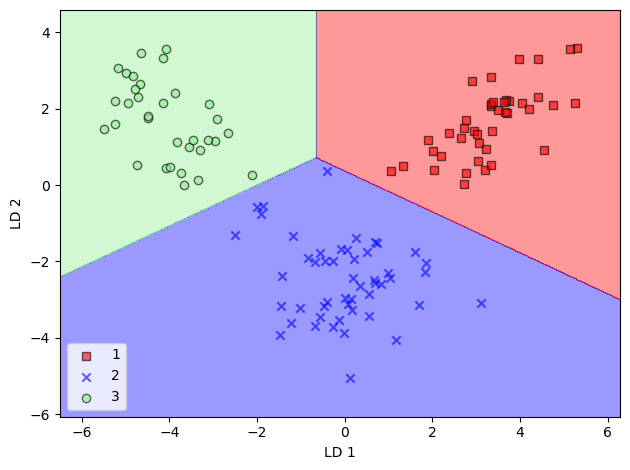

In [76]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=1)
lr = lr.fit(X_train_lda, y_train)

plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()

plt.show()

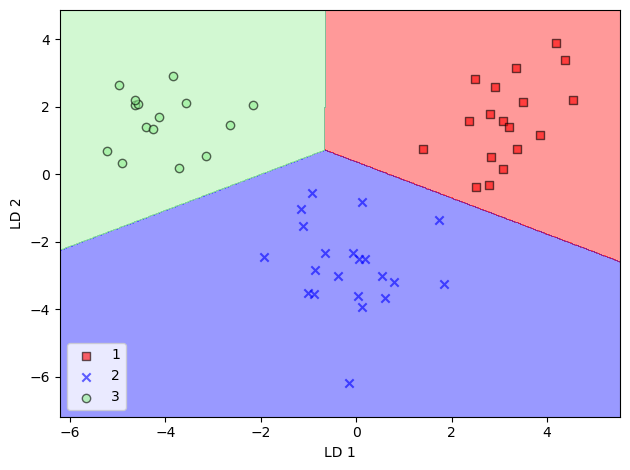

In [37]:
X_test_lda = lda.transform(X_test_std)

plot_decision_regions(X_test_lda, y_test, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()

plt.show()

사이킷런의 LDA 구현 방식

In [38]:
y_uniq, y_count = np.unique(y_train, return_counts=True)
priors = y_count / X_train_std.shape[0]
priors

array([0.3306, 0.4032, 0.2661])

In [39]:
s_w = np.zeros((X_train_std.shape[1], X_train_std.shape[1]))
for i, label in enumerate(y_uniq):
    # bais=True : 1/n로 나눈 공분산 행렬 획득
    s_w += priors[i] * np.cov(X_train_std[y_train == label].T, bias=True)

In [44]:
s_b = np.zeros((X_train_std.shape[1], X_train_std.shape[1]))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train_std[y_train == i + 1].shape[0]
    mean_vec = mean_vec.reshape(-1, 1)
    s_b += priors[i] * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)

In [45]:
import scipy
ei_val, ei_vec = scipy.linalg.eigh(s_b, s_w)
ei_vec = ei_vec[:, np.argsort(ei_val)[::-1]]

In [46]:
lda_eigen = LDA(solver='eigen')
lda_eigen.fit(X_train_std, y_train)

LinearDiscriminantAnalysis(solver='eigen')

In [47]:
# 클래스 내의 산포 행렬
np.allclose(s_w, lda_eigen.covariance_)

True

In [48]:
Sb = np.cov(X_train_std.T, bias=True) - lda_eigen.covariance_
np.allclose(Sb, s_b)

True

In [49]:
# 고유 벡터
np.allclose(lda_eigen.scalings_[:, :2], ei_vec[:, :2])

True

## 5.3 커널 PCA를 사용하여 비선형 매핑

In [50]:
Image(url='https://git.io/JtsvB', width=500) 

### 파이썬으로 커널 PCA 구현

In [51]:
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import eigh
import numpy as np

from distutils.version import LooseVersion as Version
from scipy import __version__ as scipy_version

# scipy 2.0.0에서 삭제될 예정이므로 대신 numpy.exp를 사용합니다.
if scipy_version >= Version('1.4.1'):
    from numpy import exp
else:
    from scipy import exp


def rbf_kernel_pca(X, gamma, n_components):
    """
    RBF 커널 PCA 구현

    매개변수
    ------------
    X: {넘파이 ndarray}, shape = [n_samples, n_features]
        
    gamma: float
      RBF 커널 튜닝 매개변수
        
    n_components: int
      반환할 주성분 개수

    반환값
    ------------
     X_pc: {넘파이 ndarray}, shape = [n_samples, k_features]
       투영된 데이터셋

    """
    # MxN 차원의 데이터셋에서 샘플 간의 유클리디안 거리의 제곱을 계산합니다.
    sq_dists = pdist(X, 'sqeuclidean')

    # 샘플 간의 거리를 정방 대칭 행렬로 변환합니다.
    mat_sq_dists = squareform(sq_dists)

    # 커널 행렬을 계산합니다.
    K = exp(-gamma * mat_sq_dists)

    # 커널 행렬을 중앙에 맞춥니다.
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

    # 중앙에 맞춰진 커널 행렬의 고윳값과 고유벡터를 구합니다.
    # scipy.linalg.eigh 함수는 오름차순으로 반환합니다.
    eigvals, eigvecs = eigh(K)
    eigvals, eigvecs = eigvals[::-1], eigvecs[:, ::-1]

    # 최상위 k 개의 고유벡터를 선택합니다(결과값은 투영된 샘플입니다).
    X_pc = np.column_stack([eigvecs[:, i]
                            for i in range(n_components)])

    return X_pc


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_9164\2202090713.py:11: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if scipy_version >= Version('1.4.1'):


### 예제 1: 반달 모양 구분

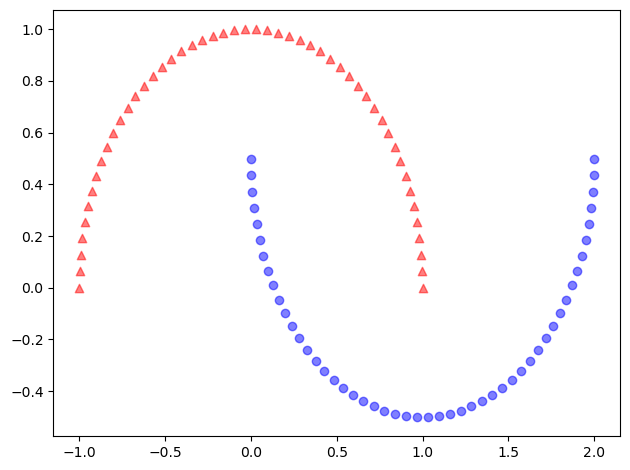

In [52]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, random_state=123)

plt.scatter(X[y == 0, 0], X[y == 0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', marker='o', alpha=0.5)

plt.tight_layout()

plt.show()

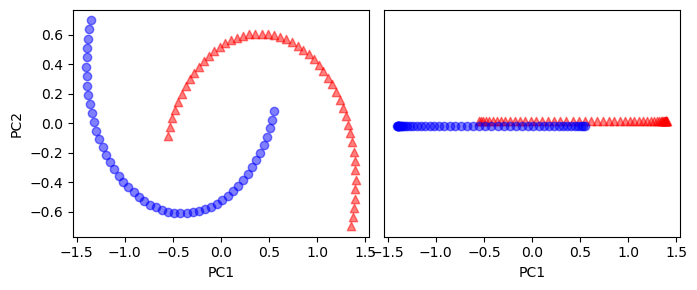

In [53]:
from sklearn.decomposition import PCA

scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))

ax[0].scatter(X_spca[y == 0, 0], X_spca[y == 0, 1],
              color='red', marker='^', alpha=0.5)
ax[0].scatter(X_spca[y == 1, 0], X_spca[y == 1, 1],
              color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_spca[y == 0, 0], np.zeros((50, 1)) + 0.02,
              color='red', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y == 1, 0], np.zeros((50, 1)) - 0.02,
              color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()

plt.show()

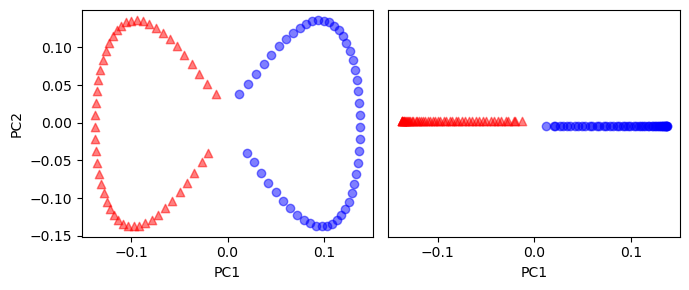

In [54]:
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
ax[0].scatter(X_kpca[y==0, 0], X_kpca[y==0, 1], 
            color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y==1, 0], X_kpca[y==1, 1],
            color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_kpca[y==0, 0], np.zeros((50, 1))+0.02, 
            color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y==1, 0], np.zeros((50, 1))-0.02,
            color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()

plt.show()

### 예제 2: 동심원 분리

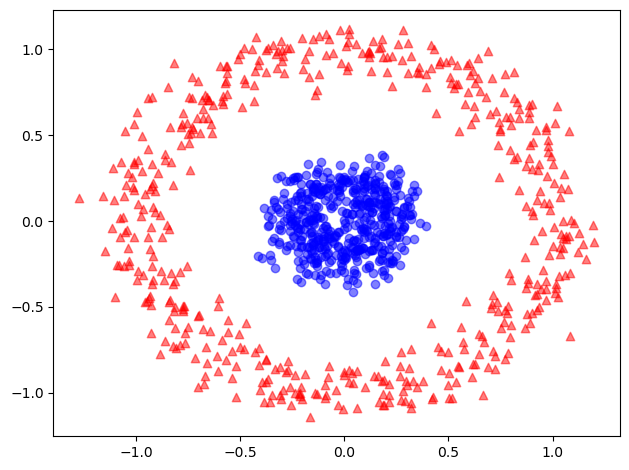

In [55]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=1000, random_state=123, noise=0.1, factor=0.2)

plt.scatter(X[y == 0, 0], X[y == 0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', marker='o', alpha=0.5)

plt.tight_layout()

plt.show()

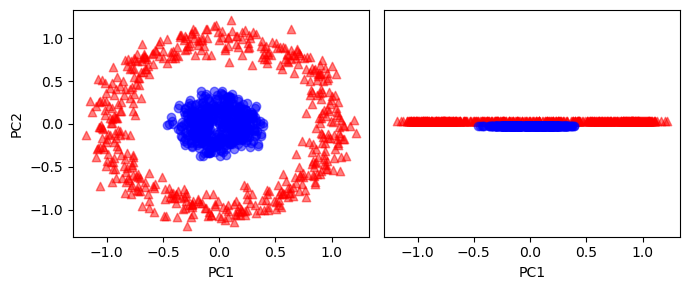

In [56]:
scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))

ax[0].scatter(X_spca[y == 0, 0], X_spca[y == 0, 1],
              color='red', marker='^', alpha=0.5)
ax[0].scatter(X_spca[y == 1, 0], X_spca[y == 1, 1],
              color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_spca[y == 0, 0], np.zeros((500, 1)) + 0.02,
              color='red', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y == 1, 0], np.zeros((500, 1)) - 0.02,
              color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()

plt.show()

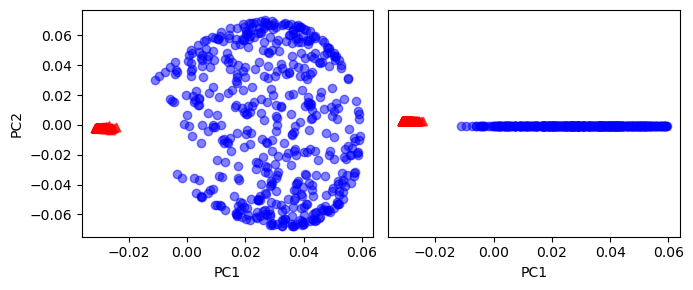

In [57]:
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
ax[0].scatter(X_kpca[y == 0, 0], X_kpca[y == 0, 1],
              color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y == 1, 0], X_kpca[y == 1, 1],
              color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_kpca[y == 0, 0], np.zeros((500, 1)) + 0.02,
              color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y == 1, 0], np.zeros((500, 1)) - 0.02,
              color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()

plt.show()

### 새로운 데이터 포인트 투영

In [58]:
from scipy.spatial.distance import pdist, squareform
from numpy import exp
from scipy.linalg import eigh
import numpy as np

def rbf_kernel_pca(X, gamma, n_components):
    """
    RBF 커널 PCA 구현

    매개변수
    ------------
    X: {넘파이 ndarray}, shape = [n_samples, n_features]
        
    gamma: float
      RBF 커널 튜닝 매개변수
        
    n_components: int
      반환할 주성분 개수

    Returns
    ------------
     alphas: {넘파이 ndarray}, shape = [n_samples, k_features]
       투영된 데이터셋
     
     lambdas: list
       고윳값

    """
    # MxN 차원의 데이터셋에서 샘플 간의 유클리디안 거리의 제곱을 계산합니다.
    sq_dists = pdist(X, 'sqeuclidean')

    # 샘플 간의 거리를 정방 대칭 행렬로 변환합니다.
    mat_sq_dists = squareform(sq_dists)

    # 커널 행렬을 계산합니다.
    K = exp(-gamma * mat_sq_dists)

    # 커널 행렬을 중앙에 맞춥니다.
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

    # 중앙에 맞춰진 커널 행렬의 고윳값과 고유 벡터를 구합니다.
    # scipy.linalg.eigh 함수는 오름차순으로 반환합니다.
    eigvals, eigvecs = eigh(K)
    eigvals, eigvecs = eigvals[::-1], eigvecs[:, ::-1]

    # 최상위 k 개의 고유 벡터를 선택합니다(투영 결과).
    alphas = np.column_stack([eigvecs[:, i]
                              for i in range(n_components)])

    # 고유 벡터에 상응하는 고윳값을 선택합니다.
    lambdas = [eigvals[i] for i in range(n_components)]

    return alphas, lambdas

In [59]:
X, y = make_moons(n_samples=100, random_state=123)
alphas, lambdas = rbf_kernel_pca(X, gamma=15, n_components=1)

In [60]:
x_new = X[25]
x_new

array([1.8713, 0.0093])

In [61]:
x_proj = alphas[25] # 원본 투영
x_proj

array([0.0788])

In [62]:
def project_x(x_new, X, gamma, alphas, lambdas):
    pair_dist = np.array([np.sum((x_new - row)**2) for row in X])
    k = np.exp(-gamma * pair_dist)
    return k.dot(alphas / lambdas)

# 새로운 데이터포인트 투영
x_reproj = project_x(x_new, X, gamma=15, alphas=alphas, lambdas=lambdas)
x_reproj 

array([0.0788])

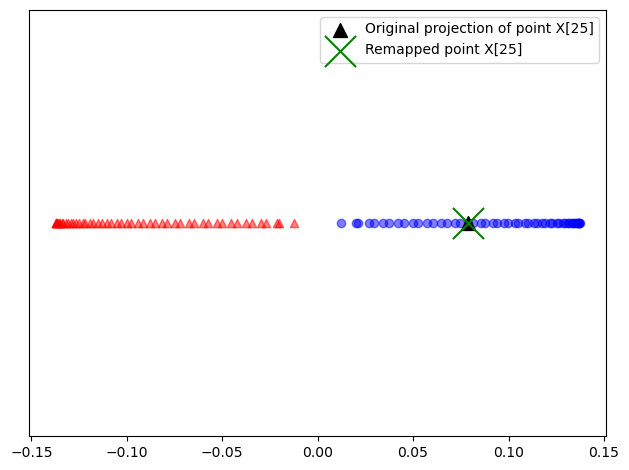

In [63]:
plt.scatter(alphas[y == 0, 0], np.zeros((50)),
            color='red', marker='^', alpha=0.5)
plt.scatter(alphas[y == 1, 0], np.zeros((50)),
            color='blue', marker='o', alpha=0.5)
plt.scatter(x_proj, 0, color='black',
            label='Original projection of point X[25]', marker='^', s=100)
plt.scatter(x_reproj, 0, color='green',
            label='Remapped point X[25]', marker='x', s=500)
plt.yticks([], [])
plt.legend(scatterpoints=1)

plt.tight_layout()

plt.show()

### 사이킷런의 커널 PCA

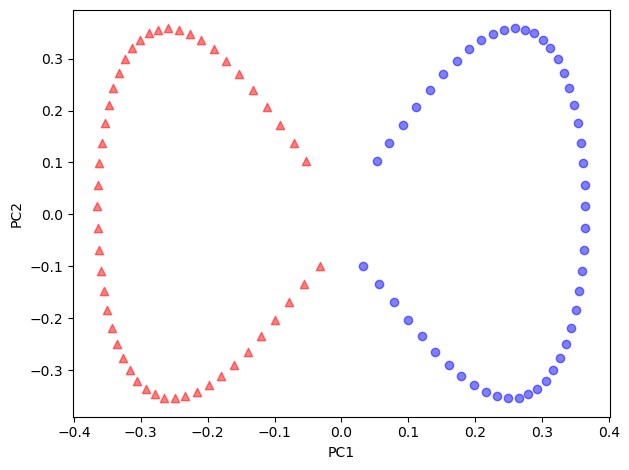

In [64]:
from sklearn.decomposition import KernelPCA

X, y = make_moons(n_samples=100, random_state=123)
scikit_kpca = KernelPCA(n_components=2, kernel='rbf', gamma=15)
X_skernpca = scikit_kpca.fit_transform(X)

plt.scatter(X_skernpca[y == 0, 0], X_skernpca[y == 0, 1],
            color='red', marker='^', alpha=0.5)
plt.scatter(X_skernpca[y == 1, 0], X_skernpca[y == 1, 1],
            color='blue', marker='o', alpha=0.5)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()

plt.show()

In [65]:
def plot_manifold(X, y, savefig_name):
    
    plt.scatter(X[y == 0, 0], X[y == 0, 1], 
                color='red', marker='^', alpha=0.5)
    plt.scatter(X[y == 1, 0], X[y == 1, 1],
                color='blue', marker='o', alpha=0.5)

    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.tight_layout()

    plt.show()

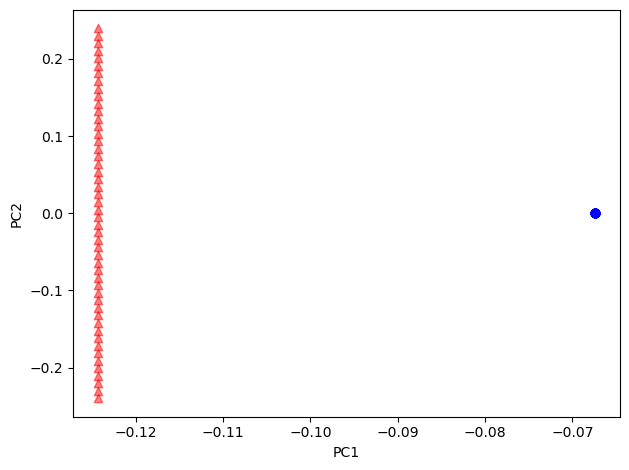

In [66]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, random_state=1)
X_lle = lle.fit_transform(X)

plot_manifold(X_lle, y, 'images/05_lle_moon.png')

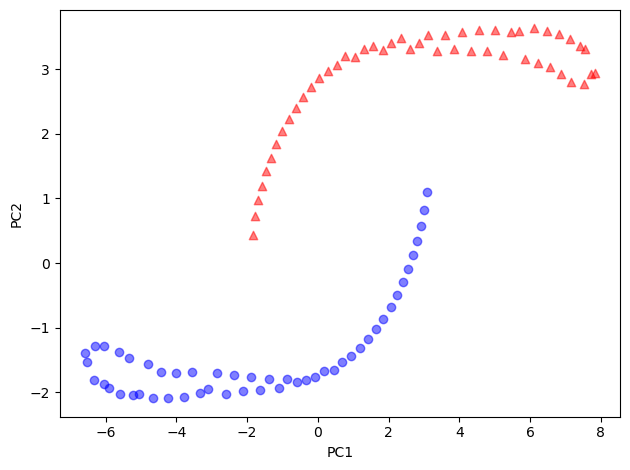

In [67]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=1)
X_tsne = tsne.fit_transform(X)

plot_manifold(X_tsne, y, 'images/05_tsne_moon.png')

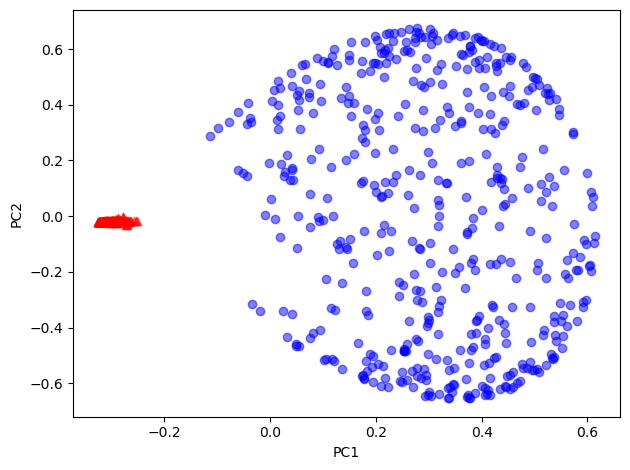

In [68]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=1000, random_state=123, noise=0.1, factor=0.2)

scikit_kpca = KernelPCA(n_components=2, kernel='rbf', gamma=15)
X_skernpca = scikit_kpca.fit_transform(X)

plot_manifold(X_skernpca, y, 'images/05_kpca_circles.png')

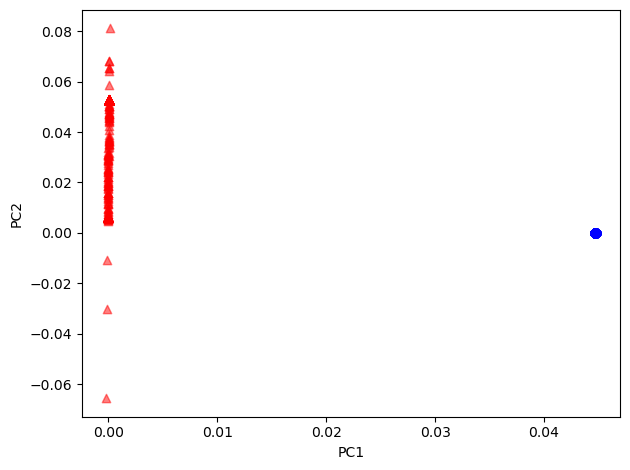

In [69]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, random_state=1)
X_lle = lle.fit_transform(X)

plot_manifold(X_lle, y, 'images/05_lle_circles.png')

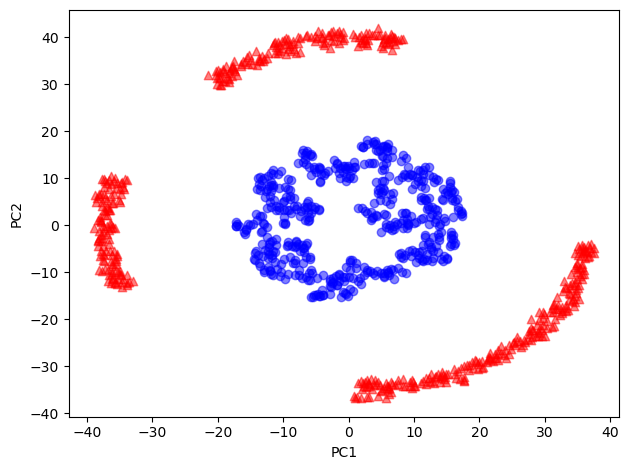

In [71]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=1)
X_tsne = tsne.fit_transform(X)

plot_manifold(X_tsne, y, 'images/05_tsne_circles.png')